In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Preprocessing

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
nulldata = data.isnull().sum()
nulldata[nulldata > 0]

ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64

In [6]:
data.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

Since this is a small dataset, I decided to fill the NA values with median instead of removing them. This might impact some accuracy of the classification.

In [7]:
clndata = data.copy()
clndata['ph'] = clndata['ph'].replace(np.NaN, clndata['ph'].median())
clndata['Sulfate'] = clndata['Sulfate'].replace(np.NaN, clndata['Sulfate'].median())
clndata['Trihalomethanes'] = clndata['Trihalomethanes'].replace(np.NaN, clndata['Trihalomethanes'].median())

In [8]:
clndata.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.074194,196.369496,22014.092526,7.122277,333.608364,426.205111,14.284970,66.407478,3.966786,0.390110
std,1.470040,32.879761,8768.570828,1.583085,36.143851,80.824064,3.308162,15.769958,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


The first step is to determine the input combination by correlation. 

In [8]:
clndata.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075760,-0.082004,-0.031741,0.014178,0.017466,0.040240,0.003145,-0.036107,-0.003014
Hardness,0.075760,1.000000,-0.046899,-0.030054,-0.092833,-0.023915,0.003610,-0.012707,-0.014449,-0.013837
Solids,-0.082004,-0.046899,1.000000,-0.070148,-0.149747,0.013831,0.010242,-0.008799,0.019546,0.033743
Chloramines,-0.031741,-0.030054,-0.070148,1.000000,0.023762,-0.020486,-0.012653,0.016614,0.002363,0.023779
Sulfate,0.014178,-0.092833,-0.149747,0.023762,1.000000,-0.014182,0.027102,-0.025657,-0.009767,-0.020476
Conductivity,0.017466,-0.023915,0.013831,-0.020486,-0.014182,1.000000,0.020966,0.001184,0.005798,-0.008128
Organic_carbon,0.040240,0.003610,0.010242,-0.012653,0.027102,0.020966,1.000000,-0.012958,-0.027308,-0.030001
Trihalomethanes,0.003145,-0.012707,-0.008799,0.016614,-0.025657,0.001184,-0.012958,1.000000,-0.021487,0.006887
Turbidity,-0.036107,-0.014449,0.019546,0.002363,-0.009767,0.005798,-0.027308,-0.021487,1.000000,0.001581
Potability,-0.003014,-0.013837,0.033743,0.023779,-0.020476,-0.008128,-0.030001,0.006887,0.001581,1.000000


The rank of correlation is Solids, Organic_carbon, Chloramines, Sulfate, Hardness, Conductivity, Trihalomethanes, ph, Turbidity

In order to replicate the method in the paper, the data will normalized to range of 0 to 1. The first model tested on the dataset is random forest. Everything will be built in a pipeline so different input featured can be trained easily.

In [9]:
train = clndata.iloc[:, 0:9]

In [10]:
combs = []

In [11]:
combs.append([2])
combs.append([2,6])
combs.append([2,6,3])
combs.append([2,6,3,4])
combs.append([2,6,3,4,1])
combs.append([2,6,3,4,1,5])
combs.append([2,6,3,4,1,5,7])
combs.append([2,6,3,4,1,5,7,0])
combs.append([2,6,3,4,1,5,7,0,8])

In [12]:
y = clndata.iloc[:, 9]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 1515)

## Logicsitc Regression

In [21]:
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    clf = LogisticRegression(random_state=0,class_weight='balanced', solver = 'liblinear').fit(X_train.iloc[:, each], y_train)
    print('accuracy score with training set:')
    print(clf.score(X_train.iloc[:, each], y_train))
    y_predicted = clf.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

accuracy score with training set:
0.48626253815961623

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.46      0.51       567
           1       0.43      0.55      0.48       416

    accuracy                           0.50       983
   macro avg       0.51      0.51      0.50       983
weighted avg       0.52      0.50      0.50       983

Training with 2 combination

accuracy score with training set:
0.5159180113388574

metrics for test set:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       567
           1       0.45      0.45      0.45       416

    accuracy                           0.54       983
   macro avg       0.52      0.52      0.52       983
weighted avg       0.54      0.54      0.54       983

Training with 3 combination

accuracy score with training set:
0.513301351940689

metrics for test set:
              precision    reca

As Logistic Regression is a simple model for classification model, it makes sense to see how it performs on this dataset before moving on to a more complex model. We can see that logistic regression is not able to detect any water that is safe to human. 

## Random Forest with balanced class weight

Random Forest is one of the models that performed well in the paper. It is also a good meta classifier.

In [17]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', RandomForestClassifier(class_weight = 'balanced')),
    ])
parameters = {
        'clf__max_depth': [10,15,20],
        'clf__max_samples': [0.3,0.6,1.0],
    }

In [18]:
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10)
    grid_search.fit(X_train.iloc[:, each], y_train)
    print('best parameter:')
    print(grid_search.best_params_)
    print('accuracy score with training set:')
    print(grid_search.score(X_train.iloc[:, each], y_train))
    y_predicted = grid_search.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

best parameter:
{'clf__max_depth': 10, 'clf__max_samples': 0.3}
accuracy score with training set:
0.7178368948975141

metrics for test set:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       567
           1       0.45      0.31      0.36       416

    accuracy                           0.55       983
   macro avg       0.52      0.51      0.51       983
weighted avg       0.53      0.55      0.53       983

Training with 2 combination

best parameter:
{'clf__max_depth': 20, 'clf__max_samples': 0.3}
accuracy score with training set:
0.8382032272132578

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.80      0.68       567
           1       0.45      0.22      0.30       416

    accuracy                           0.56       983
   macro avg       0.52      0.51      0.49       983
weighted avg       0.53      0.56      0.52       983

Training

Best performing input combination: 8

Overall accuracy: 0.64

Category 1 Precision : 0.66

Category 1 Recall : 0.31

Parameter: max depth: 15
           max samples : 0.6

### Applying cost complexity pruning

In [34]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', RandomForestClassifier(class_weight = 'balanced')),
    ])
parameters = {
        'clf__max_depth': [10,15,20],
        'clf__ccp_alpha': [0.001, 0.005, 0.01]
    }
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10)
    grid_search.fit(X_train.iloc[:, each], y_train)
    print('best parameter:')
    print(grid_search.best_params_)
    print('accuracy score with training set:')
    print(grid_search.score(X_train.iloc[:, each], y_train))
    y_predicted = grid_search.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

best parameter:
{'clf__ccp_alpha': 0.01, 'clf__max_depth': 15}
accuracy score with training set:
0.3759267335368513

metrics for test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       567
           1       0.42      1.00      0.59       416

    accuracy                           0.42       983
   macro avg       0.21      0.50      0.30       983
weighted avg       0.18      0.42      0.25       983

Training with 2 combination



C:\Users\a8196\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a8196\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a8196\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best parameter:
{'clf__ccp_alpha': 0.005, 'clf__max_depth': 10}
accuracy score with training set:
0.6070649803750545

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.86      0.70       567
           1       0.47      0.16      0.24       416

    accuracy                           0.57       983
   macro avg       0.52      0.51      0.47       983
weighted avg       0.53      0.57      0.50       983

Training with 3 combination

best parameter:
{'clf__ccp_alpha': 0.001, 'clf__max_depth': 15}
accuracy score with training set:
0.8778892280854775

metrics for test set:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       567
           1       0.49      0.36      0.42       416

    accuracy                           0.57       983
   macro avg       0.55      0.54      0.54       983
weighted avg       0.56      0.57      0.56       983

Training with 4 combination

best par

Best performing input combination: 8

Overall accuracy: 0.65

Category 1 Precision : 0.63

Category 1 Recall : 0.42

Parameter: max depth: 20
           ccp alpha : 0.001

## Basic Bagging with Logistic Regression

In [20]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', BaggingClassifier(base_estimator=LogisticRegression(random_state=0,class_weight='balanced', solver = 'liblinear'), random_state=0))
    ])
parameters = {
        'clf__max_samples': [0.3,0.6,1.0],
        'clf__max_features': [1.0],
        'clf__n_estimators': [10,15,20]
    }
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv = 10)
    grid_search.fit(X_train.iloc[:, each], y_train)
    print('best parameter:')
    print(grid_search.best_params_)
    print('accuracy score with training set:')
    print(grid_search.score(X_train.iloc[:, each], y_train))
    y_predicted = grid_search.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 1.0, 'clf__n_estimators': 20}
accuracy score with training set:
0.5276929786306149

metrics for test set:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       567
           1       0.46      0.42      0.44       416

    accuracy                           0.54       983
   macro avg       0.53      0.53      0.53       983
weighted avg       0.54      0.54      0.54       983

Training with 2 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 20}
accuracy score with training set:
0.4683820322721326

metrics for test set:
              precision    recall  f1-score   support

           0       0.62      0.44      0.52       567
           1       0.46      0.64      0.53       416

    accuracy                           0.52       983
   macro avg       0.54      0.54      0.52       983
weigh

Best performing input combination: 8

Overall accuracy: 0.54

Category 1 Precision : 0.46

Category 1 Recall : 0.42

Parameter: max features: 1.0
           max samples: 1.0
           n_estimators: 20

## Basic Bagging with RFC

In [21]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(), random_state=0))
    ])
parameters = {
        'clf__max_samples': [0.3,0.6,1.0],
        'clf__max_features': [1.0],
        'clf__n_estimators': [10,15,20]
    }
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv = 10)
    grid_search.fit(X_train.iloc[:, each], y_train)
    print('best parameter:')
    print(grid_search.best_params_)
    print('accuracy score with training set:')
    print(grid_search.score(X_train.iloc[:, each], y_train))
    y_predicted = grid_search.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 20}
accuracy score with training set:
0.7221979938944614

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       567
           1       0.43      0.21      0.28       416

    accuracy                           0.55       983
   macro avg       0.51      0.50      0.48       983
weighted avg       0.52      0.55      0.51       983

Training with 2 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 20}
accuracy score with training set:
0.74792847797645

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       567
           1       0.44      0.15      0.22       416

    accuracy                           0.56       983
   macro avg       0.51      0.51      0.46       983
weighte

Best performing input combination: 8

Overall accuracy: 0.66

Category 1 Precision : 0.76

Category 1 Recall : 0.30

Parameter: max features: 1.0
           max samples: 0.6
           n_estimators: 15

## Bagging with RFC, balanced class mode

In [22]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced'), random_state=0))
    ])
parameters = {
        'clf__max_samples': [0.3,0.6,1.0],
        'clf__max_features': [1.0],
        'clf__n_estimators': [10,15,20]
    }

In [23]:
for each in combs:
    print('Training with %d combination\n' % (len(each)))
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10)
    grid_search.fit(X_train.iloc[:, each], y_train)
    print('best parameter:')
    print(grid_search.best_params_)
    print('accuracy score with training set:')
    print(grid_search.score(X_train.iloc[:, each], y_train))
    y_predicted = grid_search.predict(X_test.iloc[:, each])
    print('\nmetrics for test set:')
    print(metrics.classification_report(y_test, y_predicted))

Training with 1 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 20}
accuracy score with training set:
0.7221979938944614

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       567
           1       0.43      0.21      0.28       416

    accuracy                           0.55       983
   macro avg       0.51      0.50      0.48       983
weighted avg       0.52      0.55      0.51       983

Training with 2 combination

best parameter:
{'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 20}
accuracy score with training set:
0.7496729175752289

metrics for test set:
              precision    recall  f1-score   support

           0       0.58      0.87      0.70       567
           1       0.42      0.12      0.19       416

    accuracy                           0.56       983
   macro avg       0.50      0.50      0.44       983
weigh

Best performing input combination: 8

Overall accuracy: 0.65

Category 1 Precision : 0.78

Category 1 Recall : 0.25

Parameter: max features: 1.0
           max samples: 1.0
           n_estimators: 20

After obtaining the best parameters, try to build a best model with the whole dataset. 

In [14]:
k_fold = KFold(n_splits = 10)

In [15]:
pipeline = Pipeline([
        ('sca', MinMaxScaler()),
        ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced', n_estimators = 20), random_state=0))
    ])

In [16]:
cross_val_score(pipeline, train.iloc[:, combs[7]], y, cv=k_fold, n_jobs=-1)

array([0.71646341, 0.74085366, 0.53353659, 0.59756098, 0.60060976,
       0.6402439 , 0.60856269, 0.49847095, 0.57492355, 0.59327217])

In [19]:
pipeline.fit(train.iloc[:, combs[7]], y)

Pipeline(steps=[('sca', MinMaxScaler()),
                ('clf',
                 BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                         n_estimators=20),
                                   random_state=0))])

In [20]:
pipeline.score(train.iloc[:, combs[7]], y)

0.9792429792429792

This data set is small, and it is possible that it doesn't represent the whole population really well. The cross validation score of the model is much lower than the accuracy score of training. 

In [24]:
y_predicted = pipeline.predict(train.iloc[:, combs[7]])
print('\nmetrics for test set:')
print(metrics.classification_report(y, y_predicted))


metrics for test set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1998
           1       1.00      0.95      0.97      1278

    accuracy                           0.98      3276
   macro avg       0.98      0.97      0.98      3276
weighted avg       0.98      0.98      0.98      3276



Extra visualizatiion

In [9]:
import matplotlib.pyplot as plt

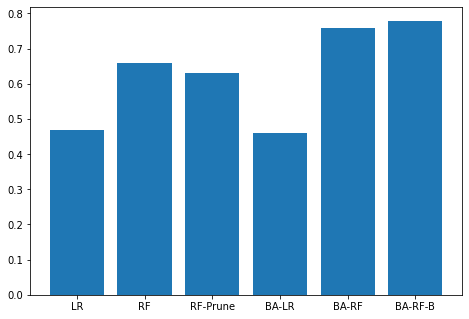

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['LR', 'RF', 'RF-Prune', 'BA-LR', 'BA-RF', 'BA-RF-B']
pre = [0.47, 0.66, 0.63, 0.46, 0.76, 0.78]
ax.bar(models, pre)
plt.show()